<a href="https://colab.research.google.com/github/marcusflygar1-hash/AH2179_Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the neccesary libraries for the project.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

Okey-



Psuedo Kod.
rensa och "clean" datan. Ta bort all null values och NaN's.

Dela sedan upp i 5 minuters tidsperioder.



## Setting up the data and cleaning etc.

In [2]:
tds = pd.read_csv('training_dataset.csv', sep=';')
ev_ds = pd.read_csv('evaluation_dataset.csv',sep=';')
f_ev_ds = pd.read_csv('final_evaluation_dataset.csv', sep=';')


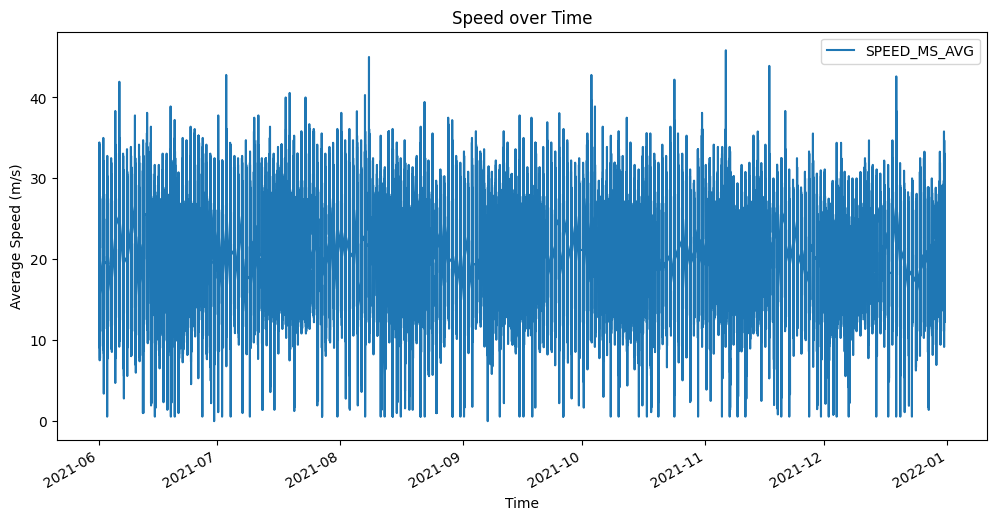

In [3]:
# Make sure Date is a string before concatenating
tds["Date"] = tds["Date"].astype(str)

# Combine Date and Time into a single datetime column
tds["datetime"] = pd.to_datetime(tds["Date"] + " " + tds["Time"])

# Plot speed vs datetime
tds.plot(x="datetime", y="SPEED_MS_AVG", kind="line", figsize=(12,6))
plt.xlabel("Time")
plt.ylabel("Average Speed (m/s)")
plt.title("Speed over Time")
plt.show()

Text(0.5, 1.0, 'Flow over Time')

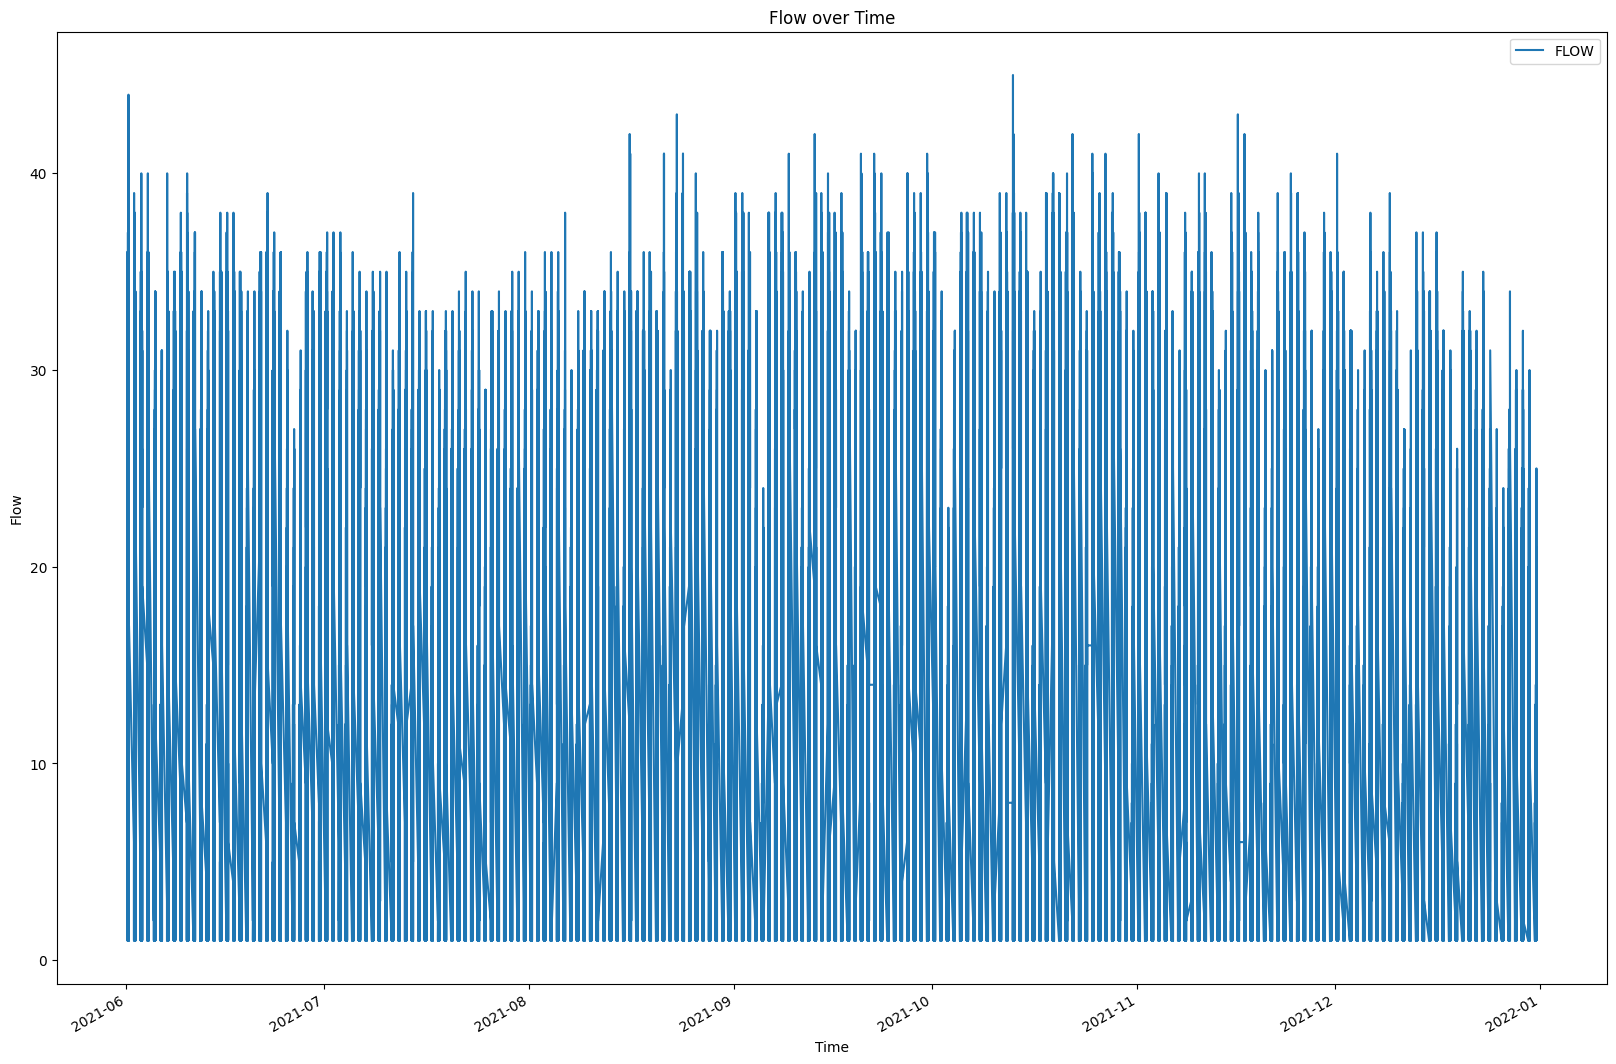

In [4]:
tds.plot(x='datetime', y='FLOW', kind='line', figsize=(20,14))
plt.xlabel('Time')
plt.ylabel('Flow')
plt.title('Flow over Time')

In [5]:
print('\n training dataset')
print(tds.head())
print('\n evaluation dataset------------')
print(ev_ds.head())
print('\n final evaluation dataset --------')
print(f_ev_ds.head())


 training dataset
   DP_ID      PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
0    543  E4S 56,780  20210601  04:00:00         240          48           16   
1    539  E4S 56,160  20210601  04:00:00         240          48           16   
2    534  E4S 56,780  20210601  04:00:00         240          48           16   
3    351  E4S 56,490  20210601  04:00:00         240          48           16   
4    353  E4S 57,055  20210601  04:00:00         240          48           16   

   Interval_30  Interval_60  SPEED_MS_AVG  FLOW            datetime  
0            8            4         19.34  10.0 2021-06-01 04:00:00  
1            8            4         19.64   9.0 2021-06-01 04:00:00  
2            8            4         23.36   5.0 2021-06-01 04:00:00  
3            8            4         20.14   7.0 2021-06-01 04:00:00  
4            8            4         17.70   7.0 2021-06-01 04:00:00  

 evaluation dataset------------
   DP_ID      PORTAL      Date      Time 

In [6]:
print('Training dataset')
print(tds.isna().sum())
print('\n eval dataset')
print(ev_ds.isna().sum())
print('\n final eval dataset')
print(f_ev_ds.isna().sum())

Training dataset
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            62
datetime         0
dtype: int64

 eval dataset
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            29
dtype: int64

 final eval dataset
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            4
dtype: int64


In [7]:
#drop all NaN values.
f_ev_ds.dropna(inplace=True)
tds.dropna(inplace=True)
ev_ds.dropna(inplace=True)

In [8]:
print('Training dataset')
print(tds.isna().sum())
print('\n eval dataset')
print(ev_ds.isna().sum())
print('\n final eval dataset')
print(f_ev_ds.isna().sum())

Training dataset
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            0
datetime        0
dtype: int64

 eval dataset
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            0
dtype: int64

 final eval dataset
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            0
dtype: int64


In [9]:
tot_days = tds['datetime'].dt.date.nunique()
print(f'the total amount of days in the dataset is: {tot_days}')
# tot_speed = tds['SPEED_MS_AVG'].sum()
# print(f'\n The total avg_speed in m/s is : {tot_speed}')
tot_flow = tds['FLOW'].sum()
print(f'\n the total flow of the dataset is:{tot_flow}')


the total amount of days in the dataset is: 214

 the total flow of the dataset is:23765351.0


We only find nan values in the flow category.

In [10]:
#define what is congestion and what is not.
# congestion_flow = tds[tds['FLOW'] < 100]
# congestion_speed = tds[tds['SPEED_MS_AVG'] < 10]

In [11]:
# filtering the dataset to only include the data within hours 04:00 and 06:00, this to get an accurate description of free flow speed.
tds_offpeak = tds[(tds['datetime'].dt.time >= pd.to_datetime("04:00:00").time()) &
                (tds['datetime'].dt.time <= pd.to_datetime("06:00:00").time())]

#Ensuring we only get correctly read speeds. E.g Removing any negative speeds and random slow drivers
#that do not actually depict the actual free flowspeed e.g people speeding and drinving super slow...
tds_offpeak = tds_offpeak[(tds_offpeak['FLOW'] > 0) &
                        (tds_offpeak['SPEED_MS_AVG'].between(5, 50))]

# Calculating the free flow speed t
# only take the observations in the 85th quantile [m/s]
ffs_ms = (tds_offpeak['SPEED_MS_AVG'].quantile(0.85))
# convert to km/h
ffs_kmh = (ffs_ms * 3.6)
print(f"Free-flow speed (85th percentile): \n Free flow speed: {ffs_ms} [m/s] \n Free flow speed {ffs_kmh} [km/h]")

Free-flow speed (85th percentile): 
 Free flow speed: 23.88 [m/s] 
 Free flow speed 85.968 [km/h]


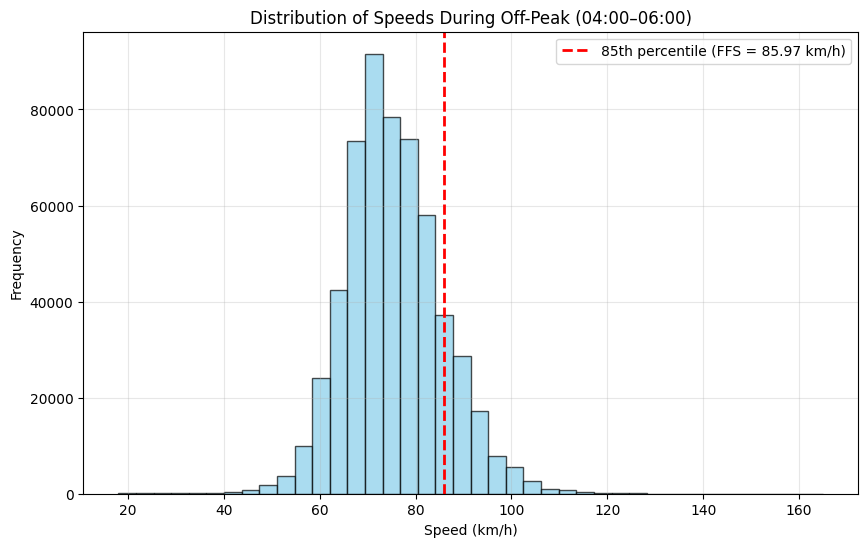

In [12]:
# Calculate FFS (85th percentile)
ffs_ms = tds_offpeak['SPEED_MS_AVG'].quantile(0.85)
ffs_kmh = ffs_ms * 3.6

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(tds_offpeak['SPEED_MS_AVG']*3.6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(ffs_kmh, color='red', linestyle='--', linewidth=2, label=f'85th percentile (FFS = {ffs_kmh:.2f} km/h)')

plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds During Off-Peak (04:00–06:00)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [13]:
# Define Congestion Threshold!
cong_th = ffs_kmh * 0.7 # why 70% of the ffs?

print(f'There is congestion at the avg. speed of: {cong_th} [km/h]')

There is congestion at the avg. speed of: 60.1776 [km/h]


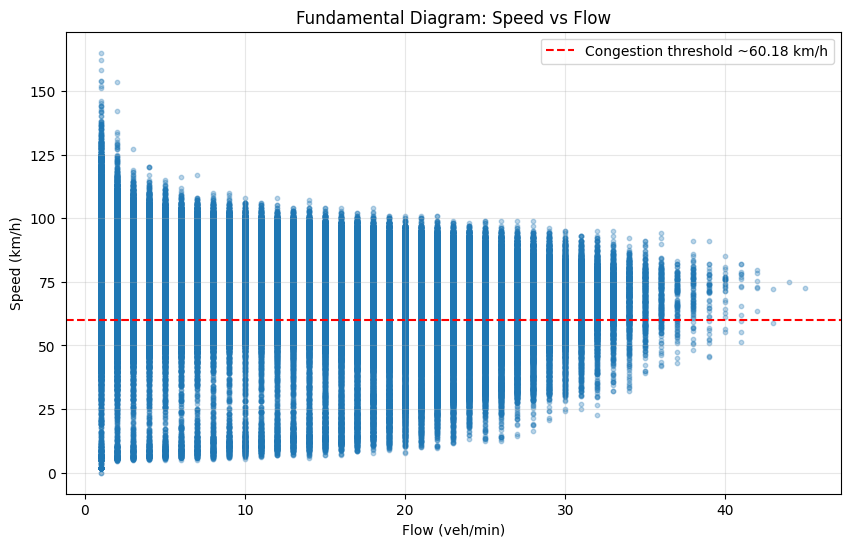

In [18]:
# plt.figure(figsize=(10,6))
# plt.scatter(tds["FLOW"], tds["SPEED_MS_AVG"]*3.6, alpha=0.3, s=10)

# # Congestion threshold line (horizontal)
# plt.axhline(y=cong_th, color='red', linestyle='--', label=f'Congestion threshold ~{cong_th:.2f} km/h')

# plt.xlabel("Flow (veh/min)")
# plt.ylabel("Speed (km/h)")
# plt.title("Fundamental Diagram: Speed vs Flow")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

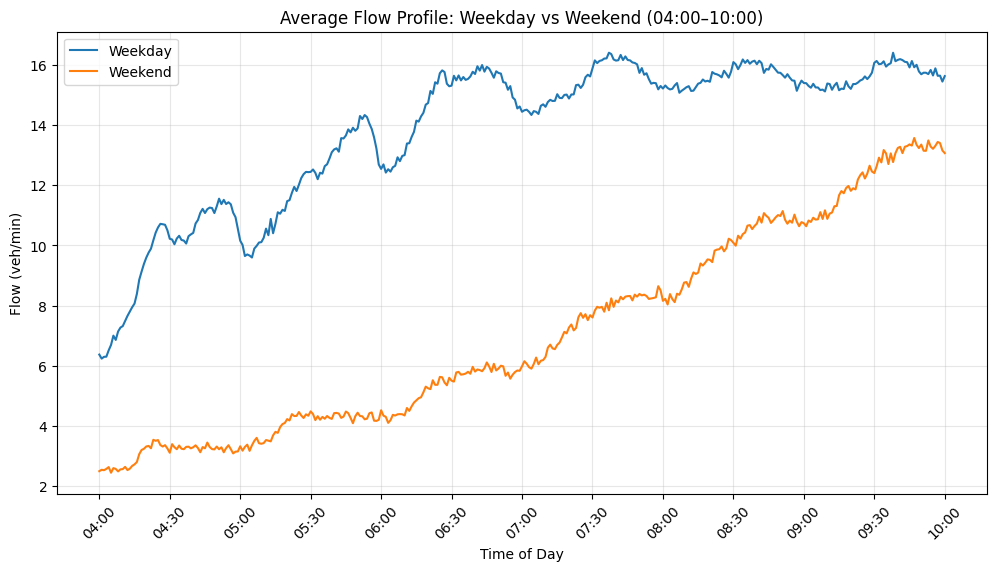

In [25]:
#minute of day
tds["minute_of_day"] = tds["datetime"].dt.hour*60 + tds["datetime"].dt.minute

# Group by weekend flag and minute of day
avg_profile = tds.groupby(["is_weekend","minute_of_day"]).agg({
    "FLOW":"mean",
    "SPEED_MS_AVG":"mean"
}).reset_index()

# We do not have data for anything outside 04:00 - 10:00, so it is removed.
avg_profile = avg_profile[(avg_profile["minute_of_day"] >= 240) & (avg_profile["minute_of_day"] <= 600)]

# Plot FLOW profiles
plt.figure(figsize=(12,6))
for wflag, label in [(0,"Weekday"), (1,"Weekend")]:
    subset = avg_profile[avg_profile["is_weekend"]==wflag]
    plt.plot(subset["minute_of_day"], subset["FLOW"], label=label)

# X-axis in hh:mm formate for interpretability.
xticks = np.arange(240, 601, 30)  # 30 minute "intervals"
xtick_labels = [f"{h:02d}:{m:02d}" for h,m in [(t//60, t%60) for t in xticks]]
plt.xticks(xticks, xtick_labels, rotation=45)

plt.title("Average Flow Profile: Weekday vs Weekend (04:00–10:00)")
plt.xlabel("Time of Day")
plt.ylabel("Flow (veh/min)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [37]:
#congested minutes
tds["is_congested"] = (tds["SPEED_MS_AVG"]*3.6 <= cong_th).astype(int)

# morning peak
tds_peak = tds[(tds["datetime"].dt.hour==7) & (tds["datetime"].dt.minute>=30) |
               (tds["datetime"].dt.hour==8) & (tds["datetime"].dt.minute<=30)]

cong_rate = tds_peak["is_congested"].mean()
print(f"Fraction of congested minutes (07:30–08:30): {cong_rate:.1%}")


Fraction of congested minutes (07:30–08:30): 13.5%


In [32]:
# features = tds[['DP_ID', 'PORTAL', 'Date', 'Time', 'Interval_1', 'Interval_5', 'Interval_15', 'Interval_30', 'Interval_60', 'FLOW']]
# target = tds[['SPEED_MS_AVG']]

# X = features.copy()
# y = target.copy()


# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [36]:
# xgb_train = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
# xgb_test = xgb.DMatrix(X_test, label=y_test, enable_categorical = True)

# params = {
#   'objective': 'binary.logistic',
#   'max_depth': 3,
#   'learning_rate': 0.1,
# }
# n= 50
# model = xgb.train(
#     params = params,
#     dtrain = xgb_train,
#     num_boost_round=n
#     )

# preds = model.predict(xgb_test)
# preds = np.round(preds)
# accuracy = accuracy_score(y_test, preds)
# print('Accuracy of the model is:', accuracy * 100)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:PORTAL: object, Date: object, Time: object